# Example notebook for generating masks for metasurfaces with pyMOE 

In the following we exemplify how to make a metasurface - while it is for a Fresnel phase mask, in general any phase profile can be used to obtain the metasurface profile. 

In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')
sys.path.insert(0,'../../..')

In [2]:
import pyMOE as moe 
import pyMOE.generate as gen 
import pyMOE.export as exp 

In [3]:
import numpy as np 
from scipy import interpolate
import matplotlib.pyplot as plt 

<IPython.core.display.Javascript object>


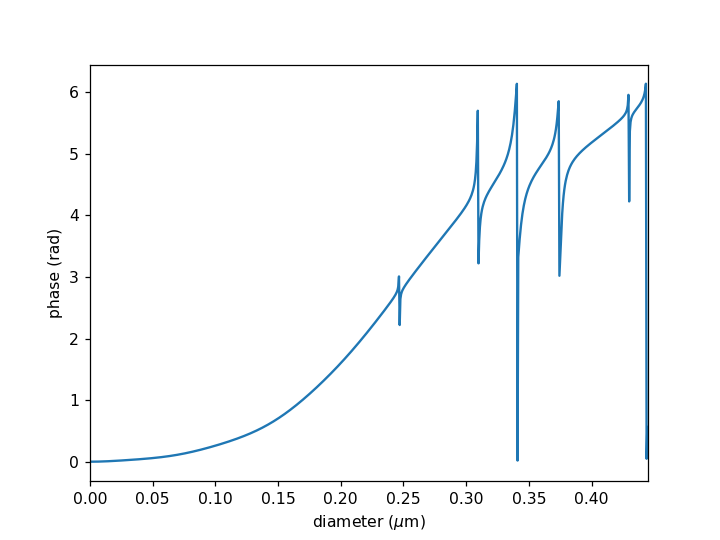

(0.0, 0.445)

In [4]:
###the curve of diameter of cylinder vs lattice const is imported  (here from RCWA calc)

dvar_cut = np.genfromtxt("dvar_638nm_p445nm.txt", delimiter=",")  
phas_cut = np.genfromtxt("phaserad_638nm_p445nm.txt", delimiter=",")  

#the periodicity 
p=0.445 # in um 

fig = plt.figure() 
plt.plot(dvar_cut, phas_cut)
plt.xlabel('diameter ($\mu$m)')
plt.ylabel('phase (rad)')
plt.xlim([0,p])
#np.max(dvar_cut)

In [5]:
from scipy import interpolate

#function that interpolates the phase difference curve 
#given a certain phase, will give us the diameter of the cylinders
func = interpolate.interp1d(phas_cut,dvar_cut, fill_value="extrapolate")

<IPython.core.display.Javascript object>


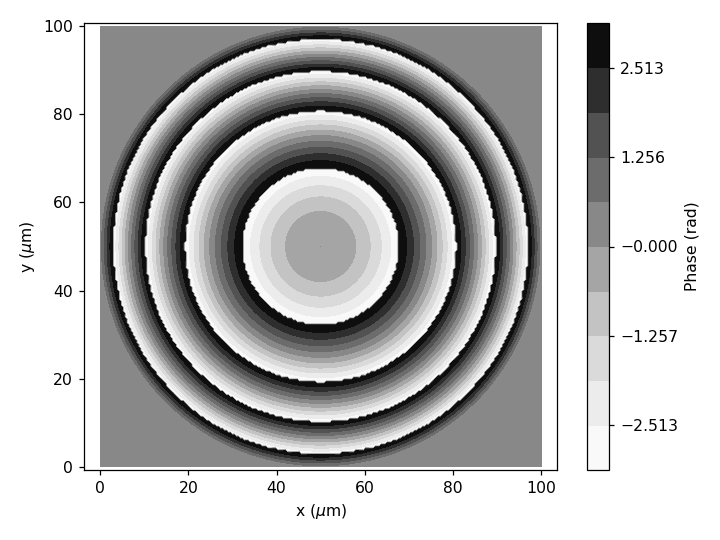

Passing contours into GDS. 
Saved the phase profile with 10 layers into the file fresnel_phase_mask.gds


In [6]:
foc = 500 # focal distance in um 
lda = 0.6328 #wavelength in um 
xsiz = 100 #um
ysiz = 100 #um
n = 10  # number of gray levels 
gdsname = 'fresnel_phase_mask.gds' # name of gds file

#TO CHECK, the number of pix seems not correct 

#calculation for the number of pixels using the size in x and the periodicity
npix = int(np.round(xsiz/p))

#obtain the phase profile of a fresnel phase mask 
fresarray_rad= moe.gen.fresnel_phase_mask(npix, foc, lda, xsiz, ysiz, n, filename=gdsname, plotting=True)


In [7]:
fresarray_rad.shape

(225, 225)

In [8]:
###transform the phase map into [0, 2*pi]
fphas = fresarray_rad + np.pi

#transform the phase map into a map of the pillar diameters 
dvars = func(fphas)
dvars

array([[0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       ...,
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956],
       [0.26153956, 0.26153956, 0.26153956, ..., 0.26153956, 0.26153956,
        0.26153956]])

<IPython.core.display.Javascript object>


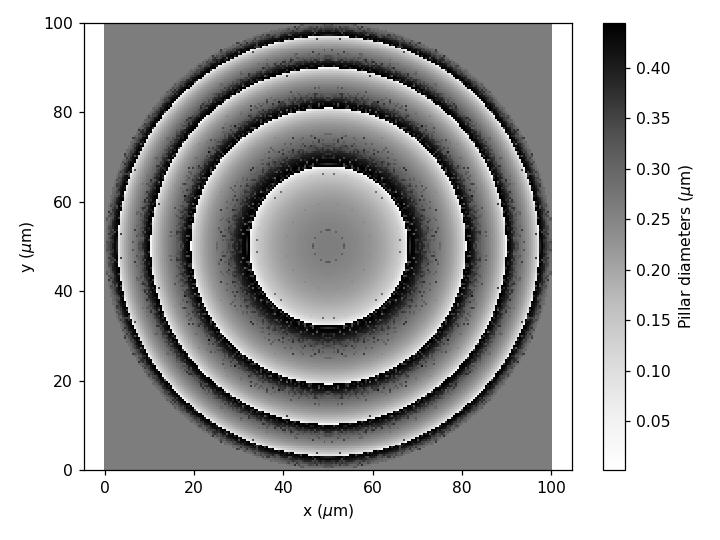

In [9]:
###Let's represent the map of the diameter of the cylinders
#clip the matrix of values within a range 
dvarx = np.clip(dvars,0,np.max(dvar_cut) )

#create the vectors for xsiz and ysiz, with npix 
xc1 = np.linspace(0, xsiz, npix)
yc1 = np.linspace(0, ysiz, npix)
(xc, yc) = np.meshgrid(xc1,yc1)
    
plt.figure()
plt.axis('equal')
plt.pcolormesh(xc,yc,dvarx, cmap=plt.get_cmap("Greys"))
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar(label='Pillar diameters ($\mu$m)')
plt.tight_layout()

In [12]:
###Transform the phase profile into a metasurface mask 

import pyMOE.metas  as metas

p = 0.445 #periodicity between pillars in um 
pixelx = p 
pixely = p 
diam_mat = dvarx 
cellname = "TOP" #name of the gds cell 
outfile = "fresnel_metasurface_pillars.gds"

moe.metas.metasurface_pillars( xsiz, ysiz, pixelx, pixely, p, diam_mat,cellname , outfile, tolerance=1e-3 ) 


Created the metasurface mask in the file fresnel_metasurface_pillars.gds


## Extra: merge layer in .gds metasurface file

In [ ]:
import pyMOE.gds_klops as gdsops

#take infile as previous outfile 
inputfile = outfile
outputfile = "fresnel_metasurface_pillars_merged.gds"
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile, cellname, layer, datatype ,outputfile )